In [1]:
import pandas
import numpy
import matplotlib
import matplotlib.pyplot as plot
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [2]:
# loading raw data from dataset
raw_data = pandas.read_csv('./datasets/addict.csv')

# convert everything to numeric data
# missing value are replaced with NoN
for column in raw_data.columns:
    raw_data[column] = pandas.to_numeric(raw_data[column], errors='coerce')

# drop all rows where PUIcutoof column is NoN
raw_data = raw_data.dropna(subset=['PUIcutoff'])

In [3]:
feature_names = [
    column for column in raw_data.columns
    if not column.startswith('TEMPS')
    and not column.startswith('Internet')
    and column not in ['ID', 'FBupotreba', 'PROT_SADR_AKT', 'RISK_SADR_AKT', 'Temper_bin', 'NKP', 'PI', 'SPO', 'PUI', 'PUIcutoff']
]

# class column for binary classification of addiction                 ]
class_name = 'PUIcutoff'

In [4]:
# calculate Pearson Correlation for all columns 
corr_data = raw_data[feature_names]                                       
corr_data.insert(0, class_name, raw_data[class_name].to_numpy())                             
cor = corr_data.corr()

cor_target = abs(cor['PUIcutoff'])                           
relevant_features = cor_target[cor_target > 0.1]             
print('List of relevant features (Pearson correlation > 0.3')
print(relevant_features)                                                                             

List of relevant features (Pearson correlation > 0.3
PUIcutoff            1.000000
Uspeh                0.181068
KolikoNedeljno       0.309938
KolikNajduze         0.210148
DaMozeDaLiBi         0.239064
Sadrzaj4             0.130964
Sadrzaj5             0.143057
Sadrzaj6             0.111744
Sadrzaj8             0.147129
Aktivnost2           0.179784
Aktivnost6           0.208247
Aktivnost8           0.133388
Aktivnost10          0.206781
Aktivnost12          0.101671
DaLiSvakodnevnoFb    0.130998
BrojaSatiFB          0.191674
EnergetskoP          0.144596
EnergetskoPml        0.132154
Alkohol_bin          0.126921
Depresivan           0.177879
Ciklotimicni         0.270440
Iritabilni           0.209510
Anksiozni            0.174712
Name: PUIcutoff, dtype: float64


In [5]:
print('Pearson correlation between individual columns')
for column_i in corr_data.columns:                                                                                               
    for column_j in corr_data.columns:                                                                                           
        if column_i != column_j:                                                                                                 
            column_corr = corr_data[[column_i, column_j]].corr()                                                                 
            if abs(column_corr.iloc[0].iloc[1]) > 0.5:                                                                           
                print("Person correlation between columns {} and {}: {}".format(column_i, column_j, column_corr.iloc[0].iloc[1]))

Pearson correlation between individual columns
Person correlation between columns Pol and Sadrzaj8: -0.7342602395539004
Person correlation between columns Sadrzaj5 and Sadrzaj6: 0.5218354342929975
Person correlation between columns Sadrzaj5 and Sadrzaj7: 0.5258146196464025
Person correlation between columns Sadrzaj6 and Sadrzaj5: 0.5218354342929975
Person correlation between columns Sadrzaj7 and Sadrzaj5: 0.5258146196464025
Person correlation between columns Sadrzaj8 and Pol: -0.7342602395539004
Person correlation between columns BrojDana and IntenzitetFizAkt: 0.5959313943430498
Person correlation between columns IntenzitetFizAkt and BrojDana: 0.5959313943430498
Person correlation between columns IntenzitetFizAkt and KolikoTrajeAkt: 0.5319552918386935
Person correlation between columns KolikoTrajeAkt and IntenzitetFizAkt: 0.5319552918386935
Person correlation between columns EnergetskoP and EnergetskoPml: -0.704378882270566
Person correlation between columns EnergetskoPml and Energetsk

In [6]:
feature_data_raw = raw_data[feature_names]                                                     
class_data = raw_data[class_name]                                                              
                                                                                               
# preprocessing data                                                                           
                                                                                               
imputer = SimpleImputer(missing_values=numpy.nan, strategy='most_frequent')                    
imputed_data = imputer.fit_transform(feature_data_raw)                                         
                                                                                               
scaler = StandardScaler()                                                                      
scaled_data = scaler.fit_transform(imputed_data)                                               
                                                                                               
feature_data_processed = pandas.DataFrame(scaled_data)                                         
feature_data_processed.columns = feature_data_raw.columns                                      
                                                                                               
# split data to trainig and test set (30% test set)                                            
train_feature_data, test_feature_data, train_class_data, test_class_data = train_test_split(feature_data_processed, class_data, test_size=0.3, stratify=class_data)   

In [7]:
# classification using LogisticRegression                                     
print('Logistic Regression classifier')                                       
# create model using training data                                            
classifier = LogisticRegression(max_iter=10000, solver='lbfgs')               
classifier.fit(train_feature_data, train_class_data)                          
                                                                              
# predict using model and test data                                           
test_predicted_data = classifier.predict(test_feature_data)                   
                                                                              
# calculatre metrics                                                          
print('score={}'.format(accuracy_score(test_class_data, test_predicted_data)))
print(confusion_matrix(test_class_data, test_predicted_data))                 
print(classification_report(test_class_data, test_predicted_data))            

Logistic Regression classifier
score=0.7512437810945274
[[294  58]
 [ 92 159]]
              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80       352
         1.0       0.73      0.63      0.68       251

    accuracy                           0.75       603
   macro avg       0.75      0.73      0.74       603
weighted avg       0.75      0.75      0.75       603



In [8]:
# using RFE (Recursive Feature Estimation)                                            
print('Logistic Regression classifier after using RFE')                               
classifier = LogisticRegression(max_iter=10000, solver='lbfgs')                       
rfe = RFE(classifier, 15)                                                             
                                                                                      
                                                                                      
rfe_data = rfe.fit_transform(feature_data_processed, class_data)                      
selected_columns = rfe.get_support(indices=True)                                      
                                                                                      
columns_rfe = [                                                                       
    feature_data_processed.columns[selected] for selected in selected_columns         
]                                                                                     
                                                                                      
print('RFE selected columns {}'.format(columns_rfe))                                  
                                                                                      
feature_data_rfe = pandas.DataFrame(rfe_data)                                         
feature_data_rfe.columns = columns_rfe                                                
                                                                                      
# split rfe data to trainig and test set (30% test set)                               
train_feature_data, test_feature_data, train_class_data, test_class_data = train_test_split(feature_data_rfe, class_data, test_size=0.3, stratify=class_data)
                                                                                      
classifier.fit(train_feature_data, train_class_data)                                  
                                                                                      
# predict using model and test data                                                   
test_predicted_data = classifier.predict(test_feature_data)                           
                                                                                      
# calculatre metrics                                                                  
print('score={}'.format(accuracy_score(test_class_data, test_predicted_data)))        
print(confusion_matrix(test_class_data, test_predicted_data))                         
print(classification_report(test_class_data, test_predicted_data))                    

Logistic Regression classifier after using RFE
RFE selected columns ['Uspeh', 'KolikoNedeljno', 'KolikNajduze', 'DaMozeDaLiBi', 'Sadrzaj4', 'Sadrzaj5', 'Sadrzaj8', 'Aktivnost6', 'DaLiSvakodnevnoFb', 'BrojaSatiFB', 'NemaFB', 'KolikoCigareta', 'Ciklotimicni', 'Hipertimicni', 'Anksiozni']
score=0.7479270315091211
[[300  52]
 [100 151]]
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80       352
         1.0       0.74      0.60      0.67       251

    accuracy                           0.75       603
   macro avg       0.75      0.73      0.73       603
weighted avg       0.75      0.75      0.74       603



Logistic Regression classifier after using RFECV


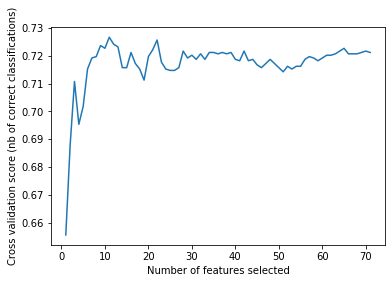

RFECV selected columns ['Uspeh', 'KolikoNedeljno', 'KolikNajduze', 'DaMozeDaLiBi', 'Sadrzaj4', 'Sadrzaj5', 'Sadrzaj8', 'Aktivnost6', 'DaLiSvakodnevnoFb', 'BrojaSatiFB', 'NemaFB', 'KolikoCigareta', 'Ciklotimicni', 'Hipertimicni', 'Anksiozni']
score=0.7379767827529021
[[289  63]
 [ 95 156]]
              precision    recall  f1-score   support

         0.0       0.75      0.82      0.79       352
         1.0       0.71      0.62      0.66       251

    accuracy                           0.74       603
   macro avg       0.73      0.72      0.72       603
weighted avg       0.74      0.74      0.73       603



In [9]:
# using RFE (Recursive Feature Estimation)                                               
print('Logistic Regression classifier after using RFECV')                                
classifier = LogisticRegression(max_iter=10000, solver='lbfgs')                          
rfecv = RFECV(estimator=classifier, step=1, cv=StratifiedKFold(2), scoring='accuracy')   
                                                                                         
rfecv_data = rfecv.fit_transform(feature_data_processed, class_data)                     
                                                                                         
# Plot number of features VS. cross-validation scores                                    
plot.figure()                                                                            
plot.xlabel("Number of features selected")                                               
plot.ylabel("Cross validation score (nb of correct classifications)")                    
plot.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)                     
plot.show()                                                                              
                                                                                         
selected_columns = rfecv.get_support(indices=True)                                       
columns_rfecv = [                                                                        
    feature_data_processed.columns[selected] for selected in selected_columns            
]                                                                                        
                                                                                         
print('RFECV selected columns {}'.format(columns_rfe))                                   
                                                                                         
feature_data_rfecv = pandas.DataFrame(rfecv_data)                                        
feature_data_rfecv.columns = columns_rfecv                                               
                                                                                         
# split rfe data to trainig and test set (30% test set)                                  
train_feature_data, test_feature_data, train_class_data, test_class_data = train_test_split(feature_data_rfecv, class_data, test_size=0.3, stratify=class_data) 
                                                                                         
classifier.fit(train_feature_data, train_class_data)                                     
                                                                                         
# predict using model and test data                                                      
test_predicted_data = classifier.predict(test_feature_data)                              
                                                                                         
# calculatre metrics                                                                     
print('score={}'.format(accuracy_score(test_class_data, test_predicted_data)))           
print(confusion_matrix(test_class_data, test_predicted_data))                            
print(classification_report(test_class_data, test_predicted_data))                       

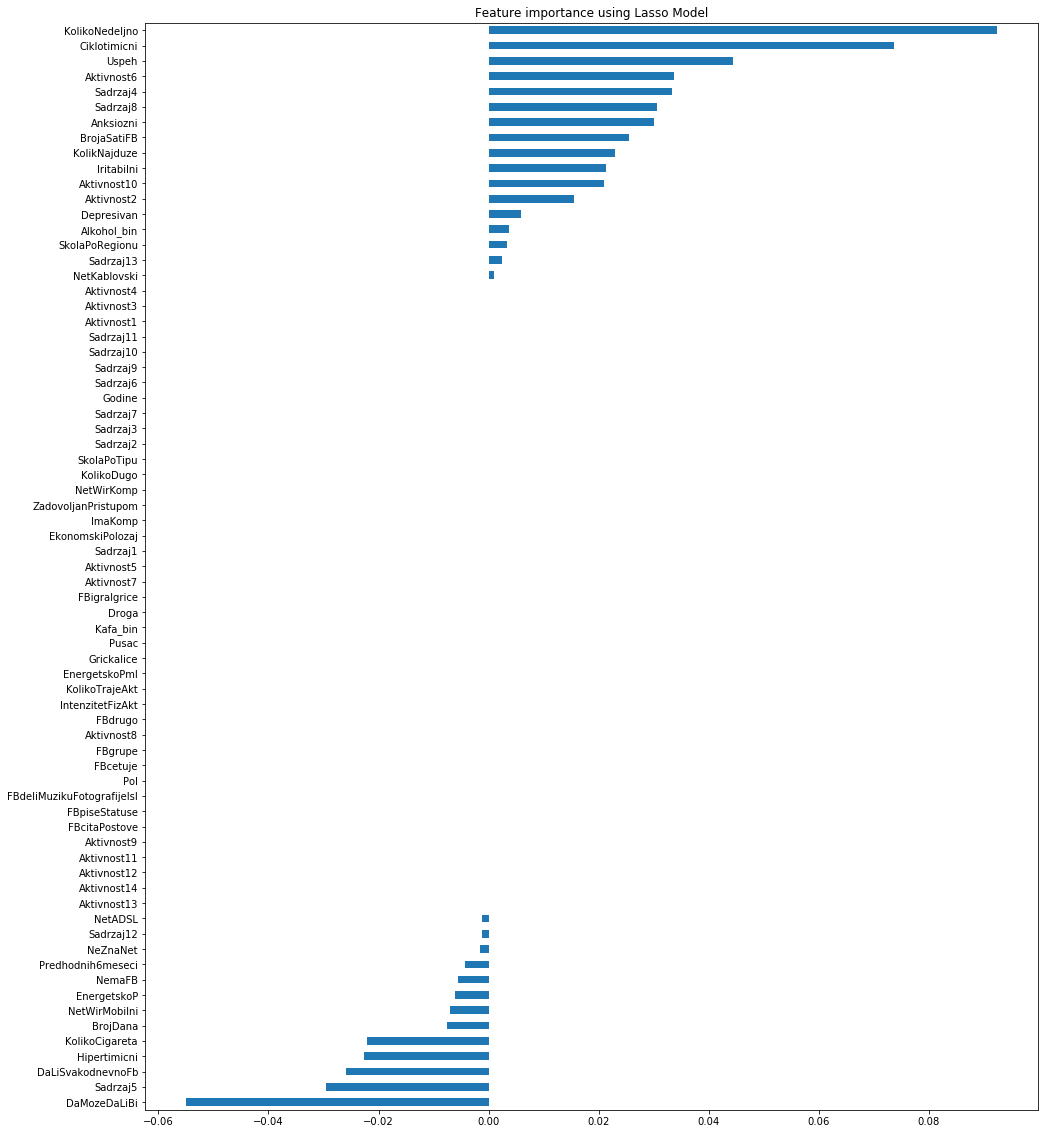

In [11]:
# feature selection using LassoCV                                       
lasso = LassoCV(cv=3)                                                   
lasso.fit(feature_data_processed, class_data)                           
coef = pandas.Series(lasso.coef_, index=feature_data_processed.columns) 
imp_coef = coef.sort_values()                                           
matplotlib.rcParams['figure.figsize'] = (16.0, 20.0)                     
imp_coef.plot(kind="barh")                                              
plot.title("Feature importance using Lasso Model")                      
plot.show()                                                             